# F: Fotometría de la secuencia de una ocultación

En este `notebook` vamos a analizar (de manera rápida y no muy precisa) los datos obtenidos en la ocultación de una estrella por parte de [Tritón](https://es.wikipedia.org/wiki/Trit%C3%B3n_(sat%C3%A9lite)) (satélite de Neptuno). Partiremos de una serie de `FITS` que tenemos en la carpeta `imagenes/ocultacionTriton/` (son un subconjunto de los datos obtenidos). Si observamos uno de dichos fotogramas veremos algo similar a esto:

[![](./ficherosAuxiliares/ocultacionTritonAnotada.png)]

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

Para analizar la secuencia de imágenes vamos a definir una serie de funciones que nos facilitarán estructurar nuestro código y conseguir la curva de luz de la ocultación:

In [2]:
def getImageData(file):
    """
    Abre un fichero fits y devuelve el array de pixeles.
    ----------
    file
        El fichero FITS a abrir
    """
    
    hdul = fits.open(light)   # Abrimos la imagen
    data = hdul[0].data
    
    return data

In [3]:
def getMaximumSource(data):
    """
    Obtiene la posición de la fuente más brillante de la imagen. Hemos ajustado los parámetros del algoritmo de detección de fuentes
    para que encuentre a Neptuno, que es la que vamos a usar para alinear las imágenes.
    ----------
    data
        Los datos de la imagen sobre la cual buscar la fuente más brillante.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   # Obtenemos datos generales de la imagen

    daofind = DAOStarFinder(fwhm=12.0, threshold=5.*std)       # Encontramos fuentes "gordas" (en nuestro caso queremos localizar Neptuno, en el centro de la imagen
    sources = daofind(data - median)  


    # print(sources)

    maxIndex = 0;                                      # Encontramos la fuente más brillante (máximo "flux")
    maxValue = 0;
    for (i, value) in enumerate(sources['flux']):
        if value > maxValue:
            maxValue = value
            maxIndex = i

    sourceMax = np.array([sources['xcentroid'][maxIndex], sources['ycentroid'][maxIndex]])  # Coordenadas de la fuente más brillante

    return sourceMax

In [4]:
def doPhotometry(data, positions):
    """
    Hacemos la fotometría propiamente dicha en las posiciones sobre una imagen y en las coordenadas que nos interesan.
    ----------
    data
        Los datos de la imagen sobre los que hacer la fotometría
    positions
        Coordenadas de las fuentes que queremos analizar
    """
    aperture = CircularAperture(positions, r=3.)       # Mediremos en un círculo de radio 3

    photTable = aperture_photometry(data, aperture)    # Hacemos la fotometría
        
    res = photTable['aperture_sum'].tolist()           # Devolvemos la suma de cuentas
    
    return res

In [5]:
def graficasFotometria(cuentasAnalizar, cuentasReferencia):
    """
    Muestra un par de gráficas. 
    La primera mostrará los datos de la fuente ocultada y la fuente de referencia.
    La segunda será la curva ajustando los valores con los de la fuente de referencia.
    ----------
    cuentasAnalizar
        Los datos de la fuente a analizar
    cuentasReferencia
        Los datos de la fuente de referencia
    """
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(cuentasAnalizar.tolist(), color ="red")
    plt.plot(cuentasReferencia.tolist(), color ="blue")
    plt.show()

    plt.plot((cuentasAnalizar/cuentasReferencia).tolist(), color ="green")
    plt.show()

A continuación programamos nuestra rutina que irá analizando cada imagen, obtenendo la posición de Neptuno para alinear los fotogramas, y ejecutando la fotometría propiamente dicha. Acabaremos con 2 arrays que contendrán las cuentas de la estrella que se oculta y la estrella de referencia.

In [6]:
lights_list = sorted(glob.glob('imagenes/ocultacionTriton/*.fit'))
#lights_list

fuenteAnalizar = np.array([453.44, 326.02])
fuenteReferencia = np.array([153.11, 570.52])

coordInit = (-10, -10)

cuentasAnalizar = np.array([])
cuentasReferencia = np.array([])

numIm = 0

for light in lights_list:
    print(".", end='')        # Imprimimos puntitos
                              #
    if (numIm + 1)%100 == 0:  #
        print("")             #
        
    if (numIm % 1) == 0:     # Solo vamos a analizar de 10 en 10 (o el número que pongamos)
        
        data = getImageData(light)                # Obtenemos datos de la imagen

        fuenteMax = getMaximumSource(data)        # Obtenemos la posición de la fuente más brillante (Neptuno en este caso)

        #print(fuenteMax)

        if (coordInit[0] == -10):                 # Si es la primera imagen guardamos sus coordenadas para luego alinear el resto.
            coordInit = np.array(fuenteMax)       #

        desv = coordInit - fuenteMax                     # Calculamos la desviación de la fuente más brillante con respecto a la primera imagen                              

        nuevaFuenteAnalizar = fuenteAnalizar - desv      # Coordenada de las fuentes que buscamos actualizadas
        nuevaFuenteReferencia = fuenteReferencia - desv  #


        posicionesAnalizar = [nuevaFuenteAnalizar, nuevaFuenteReferencia]
        
        #print(light)
        #print(posicionesAnalizar)
        
        phot = doPhotometry(data, posicionesAnalizar)    # Hacemos la fotometría de las dos fuentes

        cuentasAnalizar = np.append(cuentasAnalizar, phot[0])      # Guardamos las fotometrias para graficarlas más tarde
        cuentasReferencia = np.append(cuentasReferencia, phot[1])  #

    numIm += 1           
        
print("")

....................................................................................................
....................................................................................................
...............................


Una vez que tenemos los datos de la secuencia de imágenes podemos graficarlas. En la primera gráfica en <span style="color:red">rojo</span> tenemos los datos de la estrella ocultada. En <span style="color:blue">azul</span> la estrella de referencia. La ocultación se aprecia perfectamente pero comprobamos que tanto la estrella de referencia como la ocultada tienen un incremento más o menos lineal en su brillo (probablemente por cambios en las condiciones del cielo durante la ocultación). En la última gráfica en <span style="color:green">verde</span> ajustamos los datos de la ocultación dividiendo por los datos de referencia para corregir dicho problema y los pequeños efectos en cada fotograma.

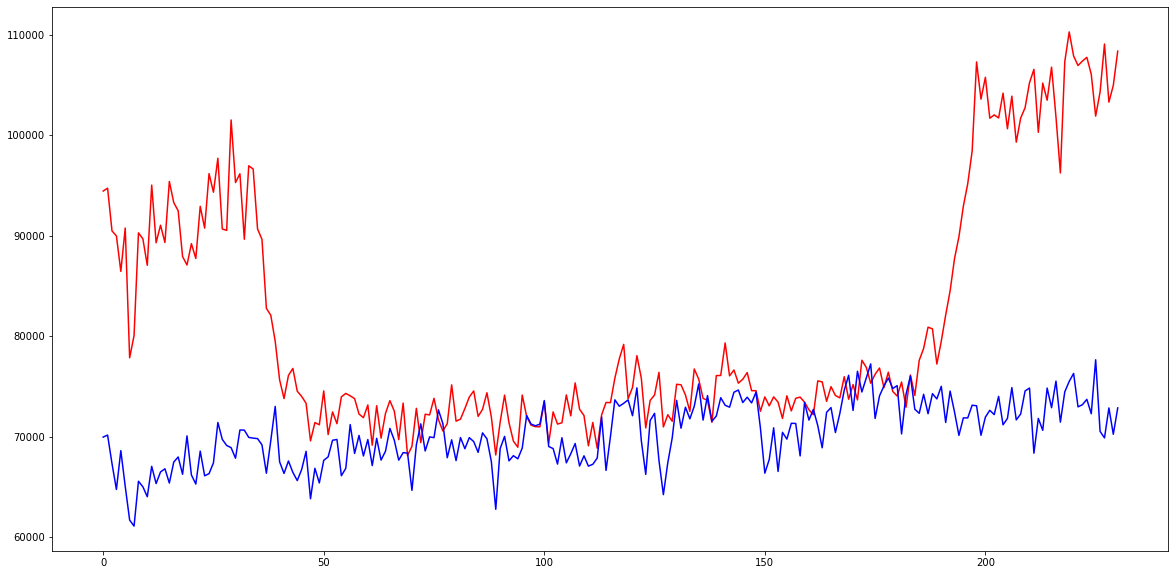

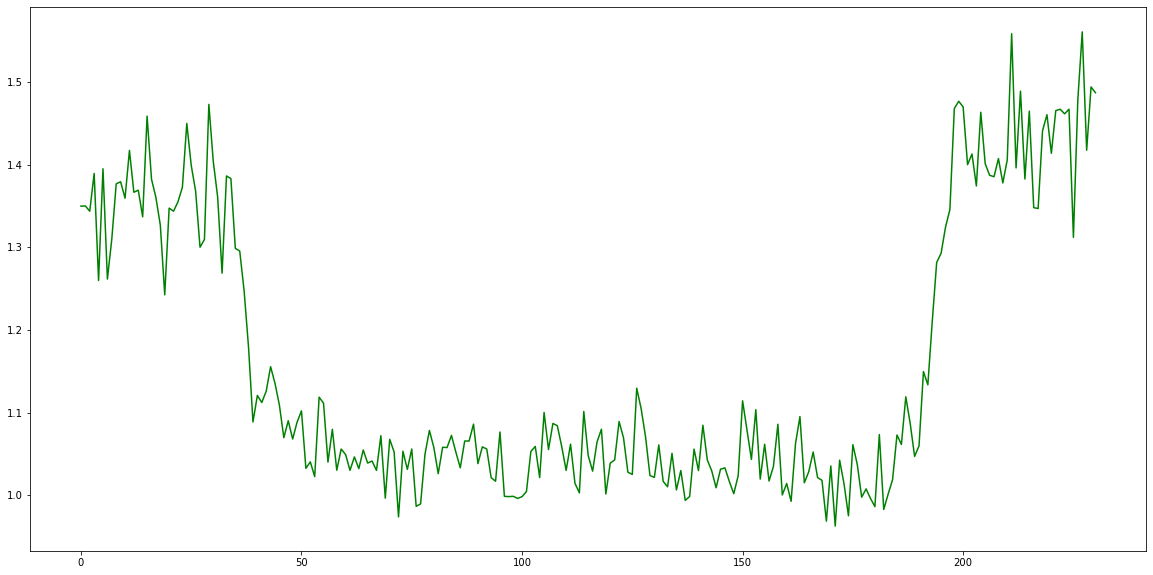

In [7]:
#print(cuentasAnalizar)
#print(cuentasReferencia)

graficasFotometria(cuentasAnalizar, cuentasReferencia)

curvaLuz = cuentasAnalizar / cuentasReferencia


# Grabamos los datos de la curva de luz
import json

with open('salidas/curvaLuz.json', 'w') as fich:
    fich.write(json.dumps(curvaLuz.tolist()))

***
**Ejercicio F.1:**

Mejorar la función que calcula la fotometría para restar el fondo utilizando un anillo alrededor de la estrella `CircularAnnules`. Para ello habrá que calcular el brillo medio de dicho anillo y restarle a las cuentas de la estrella el brillo medio multiplicado por el área de la apertura (`aperture.area`).

In [8]:
def doPhotometry2(data, positions):
  # Tu código aquí
    return res

***
**Ejercicio F.2:**

Suavizar la curva de luz obtenida usando una convolución.

In [9]:
# Tu código aquí